# Transformer Models: A Deep Dive Tutorial

**CS284A - Deep Learning**

This tutorial provides a comprehensive introduction to Transformer models, implementing a complete transformer from scratch using PyTorch. We'll cover:

1. **Attention Mechanisms**: Understanding self-attention and multi-head attention
2. **Transformer Architecture**: Encoder-decoder structure with positional encoding
3. **Implementation**: Building all components from scratch
4. **Training**: Training on a sequence-to-sequence task
5. **Visualization**: Visualizing attention patterns and training progress

## Learning Objectives

By the end of this tutorial, you will:
- Understand the core components of transformer models
- Be able to implement attention mechanisms from scratch
- Know how to build and train transformer models
- Visualize attention patterns to understand model behavior


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import math
import random
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Set style for better visualizations
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')
    except:
        pass
sns.set_palette("husl")

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


PyTorch version: 2.8.0
CUDA available: False


## 1. Understanding the Transformer Architecture

The Transformer model, introduced in "Attention Is All You Need" (Vaswani et al., 2017), revolutionized deep learning by replacing recurrent and convolutional layers with attention mechanisms.

### Key Components:
1. **Self-Attention**: Allows each position to attend to all positions in the sequence
2. **Multi-Head Attention**: Multiple attention heads capture different types of relationships
3. **Positional Encoding**: Injects information about token positions
4. **Feed-Forward Networks**: Point-wise fully connected layers
5. **Layer Normalization & Residual Connections**: Enable deep networks to train effectively


## 2. Implementing Core Components

Let's start by implementing the fundamental building blocks of a transformer.


### 2.1 Positional Encoding

Since transformers don't have recurrence or convolution, we need to add positional information to help the model understand the order of tokens.


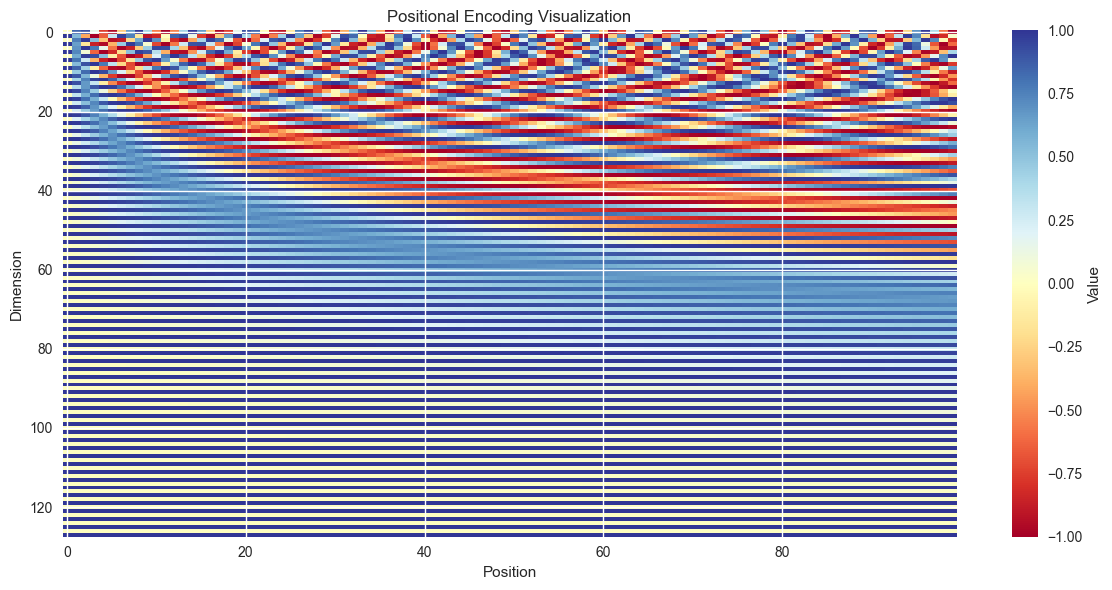

In [22]:
class PositionalEncoding(nn.Module):
    """
    Implements positional encoding using sine and cosine functions.
    
    PE(pos, 2i) = sin(pos / 10000^(2i/d_model))
    PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
    """
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Create a matrix of shape (max_len, d_model)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        
        # Register as buffer (not a parameter, but part of the model state)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch_size, seq_len, d_model)
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# Visualize positional encoding
d_model = 128
max_len = 100
pos_encoder = PositionalEncoding(d_model, max_len, dropout=0.0)  # No dropout for visualization

# Create a dummy input
dummy_input = torch.zeros(1, max_len, d_model)
pos_encoded = pos_encoder(dummy_input)

# Visualize
plt.figure(figsize=(12, 6))
plt.imshow(pos_encoded[0].T, aspect='auto', cmap='RdYlBu')
plt.colorbar(label='Value')
plt.xlabel('Position')
plt.ylabel('Dimension')
plt.title('Positional Encoding Visualization')
plt.tight_layout()
plt.show()


### 2.2 Multi-Head Self-Attention

This is the core innovation of transformers. It allows the model to jointly attend to information from different representation subspaces at different positions.


In [23]:
class MultiHeadAttention(nn.Module):
    """
    Multi-Head Self-Attention mechanism.
    
    Attention(Q, K, V) = softmax(QK^T / sqrt(d_k)) * V
    """
    def __init__(self, d_model, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        # Linear projections for Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.d_k)
    
    def forward(self, query, key, value, mask=None):
        """
        Args:
            query: (batch_size, q_len, d_model)
            key: (batch_size, k_len, d_model)
            value: (batch_size, v_len, d_model) - typically v_len == k_len
            mask: (batch_size, q_len, k_len) - optional attention mask
        Returns:
            output: (batch_size, q_len, d_model)
            attention_weights: (batch_size, num_heads, q_len, k_len) - for visualization
        """
        batch_size = query.size(0)
        q_len = query.size(1)
        k_len = key.size(1)
        v_len = value.size(1)
        
        # Linear projections and reshape for multi-head attention
        Q = self.W_q(query).view(batch_size, q_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, k_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, v_len, self.num_heads, self.d_k).transpose(1, 2)
        
        # Scaled dot-product attention
        # Q: (batch_size, num_heads, q_len, d_k)
        # K: (batch_size, num_heads, k_len, d_k)
        # scores: (batch_size, num_heads, q_len, k_len)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        
        # Apply mask if provided (set masked positions to -inf)
        if mask is not None:
            # mask should be (batch_size, 1, q_len, k_len) or broadcastable
            if mask.dim() == 2:
                mask = mask.unsqueeze(1).unsqueeze(2)  # (batch_size, 1, 1, k_len)
            elif mask.dim() == 3:
                mask = mask.unsqueeze(1)  # (batch_size, 1, q_len, k_len)
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # Apply attention to values
        # attention_weights: (batch_size, num_heads, q_len, k_len)
        # V: (batch_size, num_heads, v_len, d_k) where v_len == k_len
        context = torch.matmul(attention_weights, V)
        
        # Concatenate heads
        # context: (batch_size, num_heads, q_len, d_k)
        context = context.transpose(1, 2).contiguous().view(
            batch_size, q_len, self.d_model
        )
        
        # Final linear projection
        output = self.W_o(context)
        
        return output, attention_weights

# Test the attention mechanism
d_model = 128
num_heads = 8
batch_size = 2
seq_len = 10

attention = MultiHeadAttention(d_model, num_heads)
x = torch.randn(batch_size, seq_len, d_model)
output, attn_weights = attention(x, x, x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")


Input shape: torch.Size([2, 10, 128])
Output shape: torch.Size([2, 10, 128])
Attention weights shape: torch.Size([2, 8, 10, 10])


In [24]:
class FeedForward(nn.Module):
    """
    Position-wise Feed-Forward Network.
    FFN(x) = max(0, xW1 + b1)W2 + b2
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))


### 2.4 Encoder Layer

Combines multi-head attention, feed-forward network, layer normalization, and residual connections.


In [25]:
class EncoderLayer(nn.Module):
    """
    Transformer Encoder Layer.
    """
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        # Self-attention with residual connection and layer norm
        attn_output, attn_weights = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout1(attn_output))
        
        # Feed-forward with residual connection and layer norm
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout2(ff_output))
        
        return x, attn_weights


### 2.5 Decoder Layer

Similar to encoder but with an additional cross-attention mechanism to attend to encoder outputs.


In [26]:
class DecoderLayer(nn.Module):
    """
    Transformer Decoder Layer.
    """
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.cross_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
    
    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        # Self-attention (with causal mask for autoregressive generation)
        attn_output, self_attn_weights = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout1(attn_output))
        
        # Cross-attention (attending to encoder output)
        cross_attn_output, cross_attn_weights = self.cross_attn(
            x, encoder_output, encoder_output, src_mask
        )
        x = self.norm2(x + self.dropout2(cross_attn_output))
        
        # Feed-forward
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout3(ff_output))
        
        return x, self_attn_weights, cross_attn_weights


### 2.6 Complete Transformer Model

Now let's put it all together to create a full transformer model.


In [27]:
class Transformer(nn.Module):
    """
    Complete Transformer model (Encoder-Decoder architecture).
    """
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, num_heads=8, 
                 num_encoder_layers=6, num_decoder_layers=6, d_ff=2048, 
                 max_seq_length=5000, dropout=0.1):
        super(Transformer, self).__init__()
        
        # Embeddings
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        
        # Positional encodings
        self.pos_encoder = PositionalEncoding(d_model, max_seq_length, dropout)
        self.pos_decoder = PositionalEncoding(d_model, max_seq_length, dropout)
        
        # Encoder and Decoder stacks
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout) 
            for _ in range(num_encoder_layers)
        ])
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout) 
            for _ in range(num_decoder_layers)
        ])
        
        # Output projection
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)
        
        self.d_model = d_model
    
    def generate_mask(self, src, tgt):
        """
        Generate masks for source and target sequences.
        Returns:
            src_mask: (batch_size, 1, 1, src_len) - for encoder self-attention
            tgt_mask: (batch_size, 1, tgt_len, tgt_len) - for decoder self-attention
            src_tgt_mask: (batch_size, 1, tgt_len, src_len) - for decoder cross-attention
        """
        batch_size = src.size(0)
        src_len = src.size(1)
        tgt_len = tgt.size(1)
        
        # Source mask for encoder: (batch_size, 1, 1, src_len)
        # True where we can attend, False for padding
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        
        # Target mask for decoder self-attention: combine padding mask and causal mask
        # Padding mask: (batch_size, 1, tgt_len, 1) - True for valid tokens
        tgt_padding_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        
        # Causal mask: (1, 1, tgt_len, tgt_len) - True where j <= i
        nopeak_mask = torch.triu(torch.ones(tgt_len, tgt_len), diagonal=1).bool()
        nopeak_mask = nopeak_mask.unsqueeze(0).unsqueeze(0).to(tgt.device)
        
        # Combine: can attend if not padding AND not future position
        # (batch_size, 1, tgt_len, tgt_len)
        tgt_mask = tgt_padding_mask.expand(batch_size, 1, tgt_len, tgt_len) & (~nopeak_mask)
        
        # Cross-attention mask: (batch_size, 1, tgt_len, src_len)
        # Can attend from decoder to encoder if both positions are valid
        src_valid = (src != 0).unsqueeze(1).unsqueeze(1)  # (batch_size, 1, 1, src_len)
        tgt_valid = (tgt != 0).unsqueeze(1).unsqueeze(3)  # (batch_size, 1, tgt_len, 1)
        src_tgt_mask = src_valid.expand(batch_size, 1, tgt_len, src_len) & \
                       tgt_valid.expand(batch_size, 1, tgt_len, src_len)
        
        return src_mask, tgt_mask, src_tgt_mask
    
    def forward(self, src, tgt):
        """
        Args:
            src: Source sequence (batch_size, src_len)
            tgt: Target sequence (batch_size, tgt_len)
        Returns:
            output: (batch_size, tgt_len, tgt_vocab_size)
        """
        # Generate masks
        src_mask, tgt_mask, src_tgt_mask = self.generate_mask(src, tgt)
        
        # Encoder
        src_embedded = self.dropout(self.pos_encoder(
            self.encoder_embedding(src) * math.sqrt(self.d_model)
        ))
        
        encoder_output = src_embedded
        encoder_attentions = []
        for encoder_layer in self.encoder_layers:
            encoder_output, attn_weights = encoder_layer(encoder_output, src_mask)
            encoder_attentions.append(attn_weights)
        
        # Decoder
        tgt_embedded = self.dropout(self.pos_decoder(
            self.decoder_embedding(tgt) * math.sqrt(self.d_model)
        ))
        
        decoder_output = tgt_embedded
        decoder_self_attentions = []
        decoder_cross_attentions = []
        for decoder_layer in self.decoder_layers:
            decoder_output, self_attn, cross_attn = decoder_layer(
                decoder_output, encoder_output, src_tgt_mask, tgt_mask
            )
            decoder_self_attentions.append(self_attn)
            decoder_cross_attentions.append(cross_attn)
        
        # Output projection
        output = self.fc_out(decoder_output)
        
        return output, encoder_attentions, decoder_self_attentions, decoder_cross_attentions

print("Transformer model defined successfully!")


Transformer model defined successfully!


In [28]:
class SequenceCopyDataset(Dataset):
    """
    Dataset for sequence copying with reversal task.
    Input: [1, 2, 3, 4, 5]
    Output: [1, 2, 3, 4, 5, 5, 4, 3, 2, 1] (copy + reverse)
    """
    def __init__(self, num_samples=10000, min_len=3, max_len=10, vocab_size=20):
        self.num_samples = num_samples
        self.min_len = min_len
        self.max_len = max_len
        self.vocab_size = vocab_size
        
        # Special tokens: 0 = PAD, 1 = SOS (Start of Sequence), 2 = EOS (End of Sequence)
        self.PAD = 0
        self.SOS = 1
        self.EOS = 2
        
        self.data = []
        self._generate_data()
    
    def _generate_data(self):
        """Generate random sequences and their targets."""
        for _ in range(self.num_samples):
            # Random sequence length
            seq_len = random.randint(self.min_len, self.max_len)
            
            # Generate random sequence (starting from token 3 to avoid special tokens)
            input_seq = [random.randint(3, self.vocab_size - 1) for _ in range(seq_len)]
            
            # Target: copy + reverse
            target_seq = input_seq + input_seq[::-1]
            
            # Add SOS and EOS tokens
            input_seq = [self.SOS] + input_seq + [self.EOS]
            target_seq = [self.SOS] + target_seq + [self.EOS]
            
            self.data.append((input_seq, target_seq))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        input_seq, target_seq = self.data[idx]
        return torch.tensor(input_seq, dtype=torch.long), torch.tensor(target_seq, dtype=torch.long)

# Create dataset
train_dataset = SequenceCopyDataset(num_samples=5000, min_len=3, max_len=10, vocab_size=20)
test_dataset = SequenceCopyDataset(num_samples=1000, min_len=3, max_len=10, vocab_size=20)

# Custom collate function to pad sequences
def collate_fn(batch):
    """
    Collate function to pad sequences to the same length within a batch.
    """
    src_batch, tgt_batch = zip(*batch)
    
    # Find max lengths
    src_max_len = max([s.size(0) for s in src_batch])
    tgt_max_len = max([t.size(0) for t in tgt_batch])
    
    # Pad sequences
    src_padded = []
    tgt_padded = []
    
    for src, tgt in batch:
        # Pad source
        src_pad_len = src_max_len - src.size(0)
        src_padded.append(F.pad(src, (0, src_pad_len), value=0))
        
        # Pad target
        tgt_pad_len = tgt_max_len - tgt.size(0)
        tgt_padded.append(F.pad(tgt, (0, tgt_pad_len), value=0))
    
    # Stack into tensors
    src_tensor = torch.stack(src_padded)
    tgt_tensor = torch.stack(tgt_padded)
    
    return src_tensor, tgt_tensor

# Show some examples
print("Sample examples:")
for i in range(3):
    src, tgt = train_dataset[i]
    print(f"Input:  {src.tolist()}")
    print(f"Target: {tgt.tolist()}")
    print()


Sample examples:
Input:  [1, 3, 11, 10, 10, 2]
Target: [1, 3, 11, 10, 10, 10, 10, 11, 3, 2]

Input:  [1, 6, 5, 16, 4, 3, 2]
Target: [1, 6, 5, 16, 4, 3, 3, 4, 16, 5, 6, 2]

Input:  [1, 9, 10, 19, 3, 2]
Target: [1, 9, 10, 19, 3, 3, 19, 10, 9, 2]



## 4. Training Setup

Let's set up the training loop with proper data loading, loss function, and optimizer.


In [29]:
# Hyperparameters
VOCAB_SIZE = 20  # Including special tokens (PAD=0, SOS=1, EOS=2)
D_MODEL = 128
NUM_HEADS = 8
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
D_FF = 512
MAX_SEQ_LENGTH = 50
DROPOUT = 0.1
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 0.0001

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create data loaders with custom collate function
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Initialize model
model = Transformer(
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS,
    d_ff=D_FF,
    max_seq_length=MAX_SEQ_LENGTH,
    dropout=DROPOUT
).to(device)

# Loss function (ignoring padding tokens)
criterion = nn.CrossEntropyLoss(ignore_index=0)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


Using device: cpu
Model parameters: 1,396,244


## 5. Training Loop

Now let's train the model and track the loss.


In [30]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    
    for src, tgt in tqdm(loader, desc="Training"):
        src = src.to(device)
        tgt = tgt.to(device)
        
        # Prepare input and target for decoder
        # Input to decoder: tgt[:-1], Target: tgt[1:]
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]
        
        # Forward pass
        optimizer.zero_grad()
        output, _, _, _ = model(src, tgt_input)
        
        # Reshape for loss calculation
        output = output.reshape(-1, output.shape[-1])
        tgt_output = tgt_output.reshape(-1)
        
        # Calculate loss
        loss = criterion(output, tgt_output)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)

# Training
train_losses = []
print("Starting training...\n")

for epoch in range(NUM_EPOCHS):
    epoch_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    scheduler.step()
    train_losses.append(epoch_loss)
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

print("\nTraining completed!")


Starting training...



Training: 100%|██████████| 157/157 [00:10<00:00, 15.19it/s]


Epoch [1/20], Loss: 2.4757, LR: 0.000100


Training: 100%|██████████| 157/157 [00:10<00:00, 15.18it/s]


Epoch [2/20], Loss: 2.0142, LR: 0.000100


Training: 100%|██████████| 157/157 [00:10<00:00, 14.49it/s]


Epoch [3/20], Loss: 1.8538, LR: 0.000100


Training: 100%|██████████| 157/157 [00:10<00:00, 15.46it/s]


Epoch [4/20], Loss: 1.7333, LR: 0.000100


Training: 100%|██████████| 157/157 [00:10<00:00, 15.39it/s]


Epoch [5/20], Loss: 1.6442, LR: 0.000050


Training: 100%|██████████| 157/157 [00:10<00:00, 15.69it/s]


Epoch [6/20], Loss: 1.5827, LR: 0.000050


Training: 100%|██████████| 157/157 [00:10<00:00, 15.62it/s]


Epoch [7/20], Loss: 1.5487, LR: 0.000050


Training: 100%|██████████| 157/157 [00:10<00:00, 14.32it/s]


Epoch [8/20], Loss: 1.5209, LR: 0.000050


Training: 100%|██████████| 157/157 [00:11<00:00, 13.76it/s]


Epoch [9/20], Loss: 1.4950, LR: 0.000050


Training: 100%|██████████| 157/157 [00:10<00:00, 15.37it/s]


Epoch [10/20], Loss: 1.4717, LR: 0.000025


Training: 100%|██████████| 157/157 [00:10<00:00, 15.53it/s]


Epoch [11/20], Loss: 1.4523, LR: 0.000025


Training: 100%|██████████| 157/157 [00:10<00:00, 14.65it/s]


Epoch [12/20], Loss: 1.4368, LR: 0.000025


Training: 100%|██████████| 157/157 [00:10<00:00, 15.41it/s]


Epoch [13/20], Loss: 1.4306, LR: 0.000025


Training: 100%|██████████| 157/157 [00:10<00:00, 15.67it/s]


Epoch [14/20], Loss: 1.4157, LR: 0.000025


Training: 100%|██████████| 157/157 [00:10<00:00, 15.24it/s]


Epoch [15/20], Loss: 1.4131, LR: 0.000013


Training: 100%|██████████| 157/157 [00:10<00:00, 15.50it/s]


Epoch [16/20], Loss: 1.3982, LR: 0.000013


Training: 100%|██████████| 157/157 [00:10<00:00, 15.55it/s]


Epoch [17/20], Loss: 1.3958, LR: 0.000013


Training: 100%|██████████| 157/157 [00:10<00:00, 15.58it/s]


Epoch [18/20], Loss: 1.3933, LR: 0.000013


Training: 100%|██████████| 157/157 [00:10<00:00, 15.59it/s]


Epoch [19/20], Loss: 1.3850, LR: 0.000013


Training: 100%|██████████| 157/157 [00:10<00:00, 15.52it/s]

Epoch [20/20], Loss: 1.3843, LR: 0.000006

Training completed!


### 5.1 Visualize Training Loss


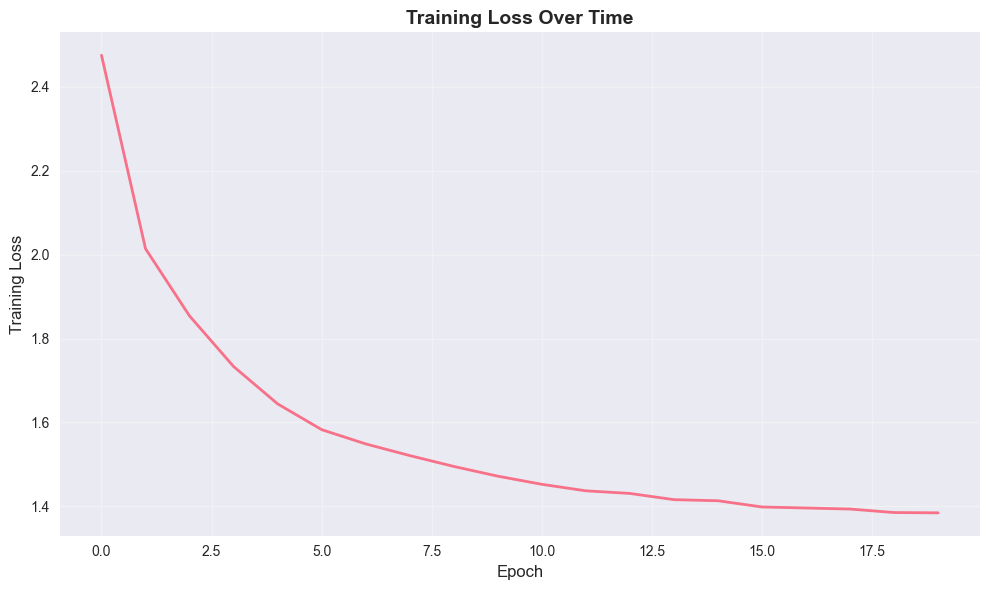

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.title('Training Loss Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 6. Testing and Evaluation

Let's evaluate the model on test data and see how well it performs.


In [32]:
def evaluate(model, loader, criterion, device):
    """Evaluate the model on test data."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for src, tgt in tqdm(loader, desc="Evaluating"):
            src = src.to(device)
            tgt = tgt.to(device)
            
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]
            
            output, _, _, _ = model(src, tgt_input)
            output = output.reshape(-1, output.shape[-1])
            tgt_output = tgt_output.reshape(-1)
            
            loss = criterion(output, tgt_output)
            total_loss += loss.item()
            
            # Calculate accuracy (excluding padding)
            predictions = output.argmax(dim=-1)
            mask = (tgt_output != 0)
            correct += (predictions[mask] == tgt_output[mask]).sum().item()
            total += mask.sum().item()
    
    avg_loss = total_loss / len(loader)
    accuracy = correct / total if total > 0 else 0
    return avg_loss, accuracy

# Evaluate
test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


Evaluating: 100%|██████████| 32/32 [00:00<00:00, 62.42it/s]


Test Loss: 1.1885
Test Accuracy: 53.98%


### 6.1 Generate Predictions

Let's see the model generate sequences on some test examples.


In [33]:
def generate_sequence(model, src, max_len=50, device='cpu'):
    """
    Generate output sequence given input sequence.
    """
    model.eval()
    src = src.unsqueeze(0).to(device) if src.dim() == 1 else src.to(device)
    
    # Start with SOS token
    tgt = torch.tensor([[1]], dtype=torch.long).to(device)  # SOS = 1
    
    with torch.no_grad():
        for _ in range(max_len):
            output, _, _, _ = model(src, tgt)
            next_token = output[:, -1, :].argmax(dim=-1, keepdim=True)
            tgt = torch.cat([tgt, next_token], dim=1)
            
            # Stop if EOS token (2) is generated
            if next_token.item() == 2:
                break
    
    return tgt[0]

# Test on some examples
model.eval()
print("Sample Predictions:\n")
print("-" * 60)

for i in range(5):
    src, tgt_true = test_dataset[i]
    tgt_pred = generate_sequence(model, src, max_len=50, device=device)
    
    # Remove SOS and EOS tokens for display
    src_display = [x for x in src.tolist() if x not in [0, 1, 2]]
    tgt_true_display = [x for x in tgt_true.tolist() if x not in [0, 1, 2]]
    tgt_pred_display = [x for x in tgt_pred.tolist() if x not in [0, 1, 2]]
    
    print(f"Example {i+1}:")
    print(f"  Input:  {src_display}")
    print(f"  Target: {tgt_true_display}")
    print(f"  Pred:   {tgt_pred_display}")
    print(f"  Match:  {'✓' if tgt_pred_display == tgt_true_display else '✗'}")
    print()


Sample Predictions:

------------------------------------------------------------
Example 1:
  Input:  [19, 14, 8, 11, 5, 15, 3, 19, 12, 6]
  Target: [19, 14, 8, 11, 5, 15, 3, 19, 12, 6, 6, 12, 19, 3, 15, 5, 11, 8, 14, 19]
  Pred:   [19, 8, 6, 14, 3, 12, 11, 15, 5, 19, 19, 5, 15, 14, 11, 8, 6, 12, 3, 19]
  Match:  ✗

Example 2:
  Input:  [13, 14, 9, 17, 10, 4, 11, 9]
  Target: [13, 14, 9, 17, 10, 4, 11, 9, 9, 11, 4, 10, 17, 9, 14, 13]
  Pred:   [9, 14, 17, 13, 11, 4, 10, 9, 9, 10, 4, 17, 14, 13, 11, 9]
  Match:  ✗

Example 3:
  Input:  [16, 9, 6, 19, 13, 14, 15, 18, 3, 18]
  Target: [16, 9, 6, 19, 13, 14, 15, 18, 3, 18, 18, 3, 18, 15, 14, 13, 19, 6, 9, 16]
  Pred:   [18, 16, 15, 9, 14, 19, 6, 13, 3, 18, 18, 16, 19, 15, 9, 18, 13, 14]
  Match:  ✗

Example 4:
  Input:  [16, 11, 11, 6]
  Target: [16, 11, 11, 6, 6, 11, 11, 16]
  Pred:   [11, 16, 6, 11, 11, 16, 6, 6, 11]
  Match:  ✗

Example 5:
  Input:  [12, 3, 3, 4, 11, 4, 17]
  Target: [12, 3, 3, 4, 11, 4, 17, 17, 4, 11, 4, 3, 3, 12]
  P

## 7. Visualizing Attention Patterns

One of the most powerful features of transformers is their interpretability through attention visualization. Let's visualize what the model is "paying attention to" when making predictions.


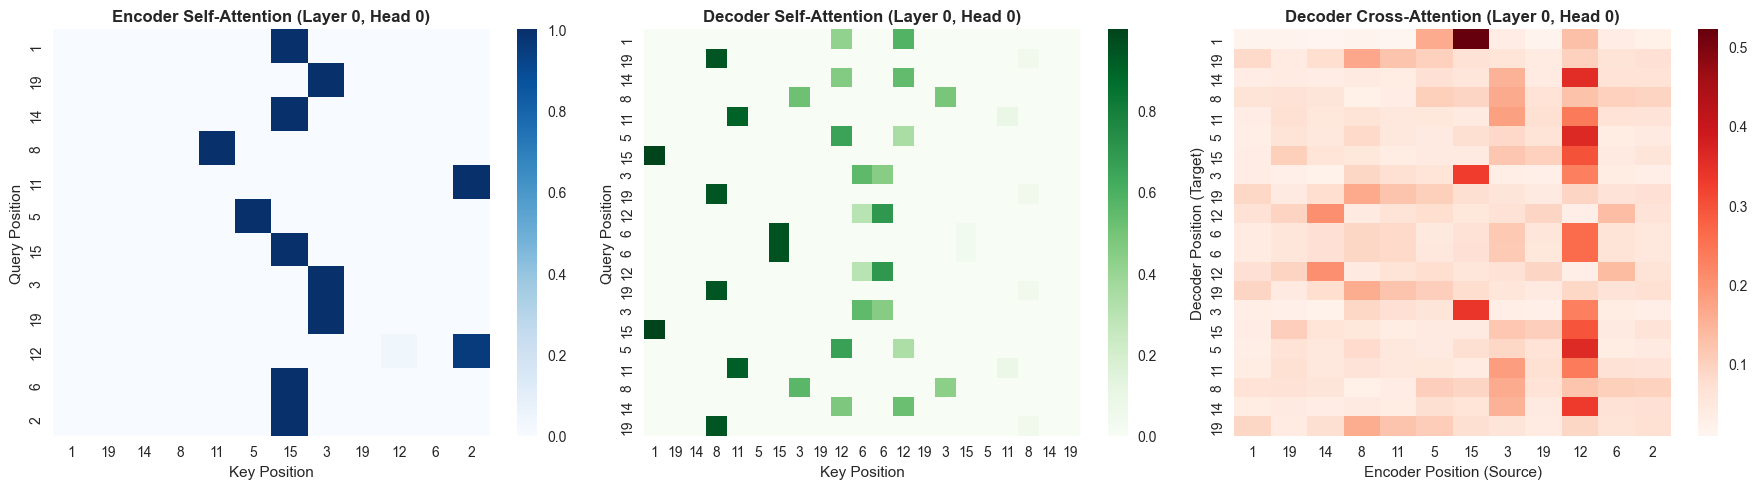

Source sequence: [1, 19, 14, 8, 11, 5, 15, 3, 19, 12, 6, 2]
Target input: [1, 19, 14, 8, 11, 5, 15, 3, 19, 12, 6, 6, 12, 19, 3, 15, 5, 11, 8, 14, 19]


In [ ]:
def visualize_attention(model, src, tgt_input, layer_idx=0, head_idx=0, device='cpu'):
    """
    Visualize attention weights from a specific layer and head.
    """
    model.eval()
    src = src.unsqueeze(0).to(device) if src.dim() == 1 else src.to(device)
    tgt_input = tgt_input.unsqueeze(0).to(device) if tgt_input.dim() == 1 else tgt_input.to(device)
    
    with torch.no_grad():
        # Get encoder output and attention
        src_embedded = model.pos_encoder(
            model.encoder_embedding(src) * math.sqrt(model.d_model)
        )
        encoder_output = src_embedded
        encoder_attentions = []
        for encoder_layer in model.encoder_layers:
            encoder_output, attn_weights = encoder_layer(encoder_output, None)
            encoder_attentions.append(attn_weights)
        
        # Get decoder attention
        tgt_embedded = model.pos_decoder(
            model.decoder_embedding(tgt_input) * math.sqrt(model.d_model)
        )
        decoder_output = tgt_embedded
        decoder_self_attentions = []
        decoder_cross_attentions = []
        for decoder_layer in model.decoder_layers:
            decoder_output, self_attn, cross_attn = decoder_layer(
                decoder_output, encoder_output, None, None
            )
            decoder_self_attentions.append(self_attn)
            decoder_cross_attentions.append(cross_attn)
    
    # Extract attention weights (average across batch if needed)
    encoder_attn = encoder_attentions[layer_idx][0, head_idx].detach().cpu().numpy()
    decoder_self_attn = decoder_self_attentions[layer_idx][0, head_idx].detach().cpu().numpy()
    decoder_cross_attn = decoder_cross_attentions[layer_idx][0, head_idx].detach().cpu().numpy()
    
    return encoder_attn, decoder_self_attn, decoder_cross_attn

# Get a test example
src, tgt = test_dataset[0]
tgt_input = tgt[:-1]  # Remove last token for input

# Visualize attention
encoder_attn, decoder_self_attn, decoder_cross_attn = visualize_attention(
    model, src, tgt_input, layer_idx=0, head_idx=0, device=device
)

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Encoder self-attention
sns.heatmap(encoder_attn, ax=axes[0], cmap='Blues', cbar=True, 
            xticklabels=src.tolist(), yticklabels=src.tolist())
axes[0].set_title('Encoder Self-Attention (Layer 0, Head 0)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Key Position')
axes[0].set_ylabel('Query Position')

# Decoder self-attention
sns.heatmap(decoder_self_attn, ax=axes[1], cmap='Greens', cbar=True,
            xticklabels=tgt_input.tolist(), yticklabels=tgt_input.tolist())
axes[1].set_title('Decoder Self-Attention (Layer 0, Head 0)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Key Position')
axes[1].set_ylabel('Query Position')

# Decoder cross-attention
sns.heatmap(decoder_cross_attn, ax=axes[2], cmap='Reds', cbar=True,
            xticklabels=src.tolist(), yticklabels=tgt_input.tolist())
axes[2].set_title('Decoder Cross-Attention (Layer 0, Head 0)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Encoder Position (Source)')
axes[2].set_ylabel('Decoder Position (Target)')

plt.tight_layout()
plt.show()

print(f"Source sequence: {src.tolist()}")
print(f"Target input: {tgt_input.tolist()}")


### 7.1 Visualize All Attention Heads

Let's see how different attention heads capture different patterns.


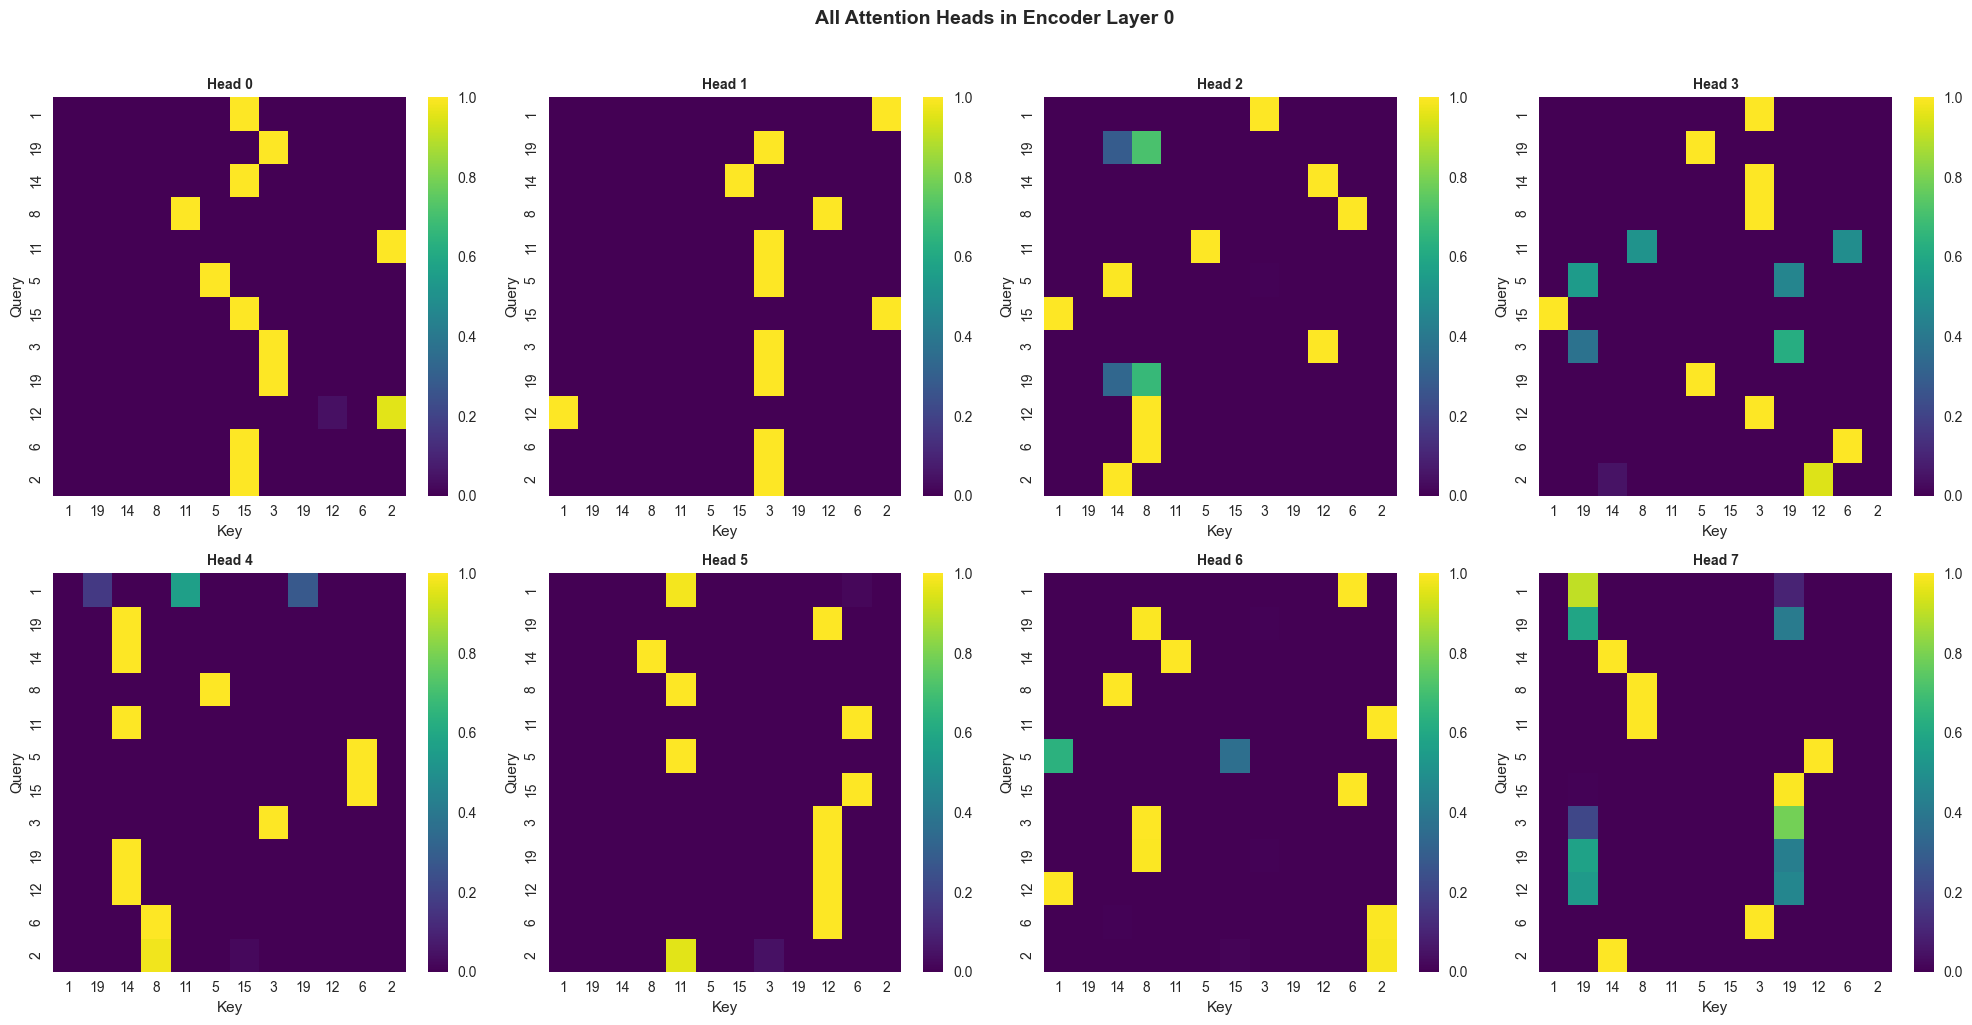

In [36]:
# Visualize all heads in the first encoder layer
src, tgt = test_dataset[0]
tgt_input = tgt[:-1]

model.eval()
src_tensor = src.unsqueeze(0).to(device)
src_embedded = model.pos_encoder(
    model.encoder_embedding(src_tensor) * math.sqrt(model.d_model)
)
encoder_output = src_embedded
_, attn_weights = model.encoder_layers[0](encoder_output, None)

# Extract all heads
all_heads = attn_weights[0].detach().cpu().numpy()  # Shape: (num_heads, seq_len, seq_len)

# Create subplot for each head
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for head_idx in range(NUM_HEADS):
    sns.heatmap(all_heads[head_idx], ax=axes[head_idx], cmap='viridis', 
                cbar=True, xticklabels=src.tolist(), yticklabels=src.tolist())
    axes[head_idx].set_title(f'Head {head_idx}', fontsize=10, fontweight='bold')
    axes[head_idx].set_xlabel('Key')
    axes[head_idx].set_ylabel('Query')

plt.suptitle('All Attention Heads in Encoder Layer 0', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


### 7.2 Visualize Attention Across Layers

Let's see how attention patterns evolve through different layers.


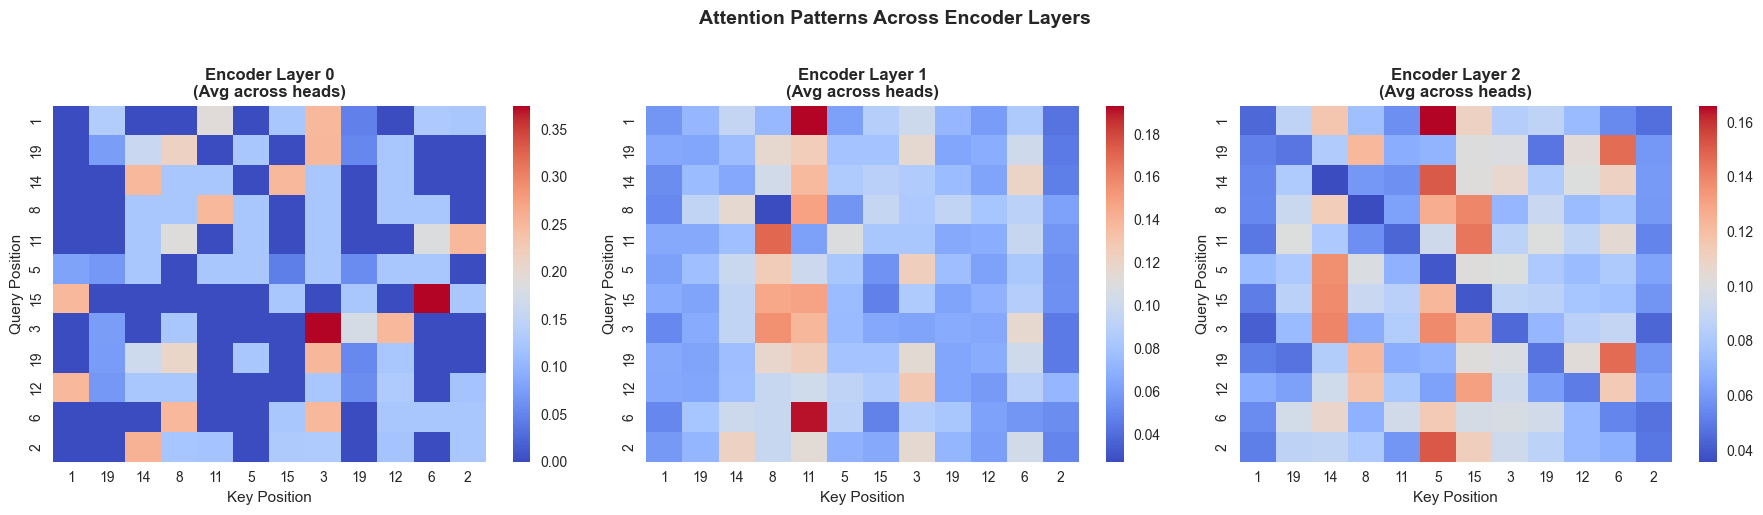

In [37]:
# Get attention from all encoder layers
src, tgt = test_dataset[0]
tgt_input = tgt[:-1]

model.eval()
src_tensor = src.unsqueeze(0).to(device)
src_embedded = model.pos_encoder(
    model.encoder_embedding(src_tensor) * math.sqrt(model.d_model)
)

encoder_output = src_embedded
all_layer_attentions = []

for layer_idx, encoder_layer in enumerate(model.encoder_layers):
    encoder_output, attn_weights = encoder_layer(encoder_output, None)
    # Average across heads for cleaner visualization
    avg_attn = attn_weights[0].mean(dim=0).detach().cpu().numpy()
    all_layer_attentions.append(avg_attn)

# Visualize
fig, axes = plt.subplots(1, NUM_ENCODER_LAYERS, figsize=(6*NUM_ENCODER_LAYERS, 5))

for layer_idx in range(NUM_ENCODER_LAYERS):
    sns.heatmap(all_layer_attentions[layer_idx], ax=axes[layer_idx], 
                cmap='coolwarm', cbar=True, 
                xticklabels=src.tolist(), yticklabels=src.tolist())
    axes[layer_idx].set_title(f'Encoder Layer {layer_idx}\n(Avg across heads)', 
                              fontsize=12, fontweight='bold')
    axes[layer_idx].set_xlabel('Key Position')
    axes[layer_idx].set_ylabel('Query Position')

plt.suptitle('Attention Patterns Across Encoder Layers', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 8. Key Takeaways

### What We've Learned:

1. **Attention Mechanism**: The core innovation that allows transformers to capture long-range dependencies without recurrence.

2. **Multi-Head Attention**: Different heads learn to attend to different aspects of the input, providing rich representations.

3. **Positional Encoding**: Critical for transformers since they don't have inherent notion of sequence order.

4. **Layer Normalization & Residual Connections**: Enable training of deep transformer networks.

5. **Encoder-Decoder Architecture**: The encoder processes the input, and the decoder generates the output while attending to encoder states.

### Why Transformers are Powerful:

- **Parallelization**: Unlike RNNs, all positions can be processed in parallel
- **Long-range Dependencies**: Self-attention can directly connect distant positions
- **Interpretability**: Attention weights provide insights into model decisions
- **Scalability**: Can be scaled to billions of parameters (GPT, BERT, etc.)

### Next Steps:

- Experiment with different tasks (machine translation, text generation, etc.)
- Try different architectures (encoder-only like BERT, decoder-only like GPT)
- Explore pre-trained models and fine-tuning
- Study advanced techniques (relative positional encoding, sparse attention, etc.)


## 9. Additional Experiments

Try modifying the following to deepen your understanding:

1. **Change the task**: Modify the dataset to implement other sequence tasks
2. **Adjust hyperparameters**: Experiment with different model sizes, learning rates, etc.
3. **Add more layers**: See how depth affects performance
4. **Analyze failure cases**: Look at examples where the model fails and understand why
5. **Compare with RNNs**: Implement the same task with an RNN and compare performance
